In [122]:
# Import necessary libraries
import os
os.chdir("C:/Users/Pauli/OneDrive/Dokumente/Uni/Masterarbeit/code/preprocessing")
import pandas as pd
import numpy as np
import pickle
#nn modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
#metrics and plotting
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
#other
from datasplit import get_datasplit
from featurescaling import scale_features
from earlystopper import EarlyStopper
import copy


Choose which Features are used as Input

In [123]:
# choose which feature set to use ligands either mordred or morgan fingerprints and kinases either ascii or propy features
feature_set_ligand = "Mordred_Features"  # "Mordred_Features" or "Morgan_Fingerprints" or None for ligands   !! None doesnt work yet !!
feature_set_kinase = "ascii"   # "ascii" [or "Sequences_propy" or "Pocket_Sequences_propy"] or None for kinases !! None doesnt work yet !!

Load the Data

In [131]:
#load necessary data
#open multi index pickle file
with open("data_split_multiind.pkl", "rb") as f:
    [ind_train, ind_val, ind_test, ind_holdout] = pickle.load(f)

#Load Kinase-ligand-K_off dataset
df_target_value = pd.read_excel("kinase_ligand_k_off.xlsx", sheet_name='kinase_ligand_k_off')
df_target_value = df_target_value.dropna(subset=["log_koff"])  #drop rows with missing target value

#set feature_range for scalers if mordred
if feature_set_ligand == "Mordred_Features":
    feature_range = (-1, 1)
else:
    feature_range = (0, 1)

#prepare feature dataframe
if feature_set_ligand and feature_set_kinase:
    df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
    df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)
elif feature_set_ligand:
    df_ligand = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Ligand_"+feature_set_ligand)
elif feature_set_kinase:
    df_kinase = pd.read_excel("ligand_and_kinase_features_data.xlsx", sheet_name="Kinase_"+feature_set_kinase)
else:
    raise ValueError("At least one feature set must be selected.")

    
#merge dataframes
df = pd.merge(df_target_value, df_ligand, on="ligand", how="left") 
df_all = pd.merge(df, df_kinase, on="kinase", how="left")
df_all.dropna(subset=["log_koff"], inplace=True)  #drop rows with missing target value

#get iris split from my cleaned data set
df_train = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_train)].copy()
df_val = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_val)].copy()
df_test = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_test)].copy()
df_holdout = df_all[df_all.set_index(["kinase", "ligand"]).index.isin(ind_holdout)].copy()
#merge train and val for final training
df_train = pd.merge(df_train, df_val, how="outer")

In [125]:
ligand_selectors = {
    "Mordred_Features":      lambda df: df.loc[:, "ABC":"mZagreb2"],
    "Morgan_Fingerprints":   lambda df: df.loc[:, "morgan__0":"morgan__2047"],
    None:                    lambda df: df.iloc[:, 0:0],  # empty
}

kinase_selectors = {
    "ascii":                     lambda df: df.loc[:, "0":"84"],          # columns named "0".."84"
    "Sequences_propy":           lambda df: df.loc[:, "AAC":"APAAC"],
    "Pocket_Sequences_propy":    lambda df: df.loc[:, "AAC":"APAAC"],
    None:                        lambda df: df.iloc[:, 0:0],  # empty
}

In [126]:
ligand_cols = ligand_selectors[feature_set_ligand](df_train).columns.tolist()
kinase_cols = kinase_selectors[feature_set_kinase](df_train).columns.tolist()

Feature Scaling

In [127]:
from sklearn.preprocessing import MinMaxScaler
#features
X_ligand_train = df_train[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
X_kinase_train = df_train[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
#target value
y_raw = df_train["log_koff"].values.reshape(-1, 1)
#independet scalers
x_scaler_ligand = MinMaxScaler(feature_range)
x_scaler_kinase = MinMaxScaler(feature_range)
y_scaler = MinMaxScaler(feature_range)
#fit scalers
x_scaler_ligand.fit(X_ligand_train) 
x_scaler_kinase.fit(X_kinase_train)
y_scaler.fit(y_raw)


MinMaxScaler()

Prepare Tensors

In [128]:
#function to prepare tensors from dataframe
def prepare_tensors(df, ligand_cols, kinase_cols, y_scaler, x_scaler_ligand, x_scaler_kinase):
    y = (df["log_koff"].values).reshape(-1, 1)
    y_scaled = y_scaler.transform(y)
    if feature_set_ligand == "Morgan_Fingerprints": #morgan fingerprints dont need to be scaled
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_kinase = df[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
        X = np.hstack([X_scaled_kinase, X_ligand])
        print("Using unscaled Morgan Fingerprints for ligands.")
    else:
        X_ligand = df[ligand_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_kinase = df[kinase_cols].apply(pd.to_numeric, errors="coerce").fillna(0).values
        X_scaled_kinase = x_scaler_kinase.transform(X_kinase)
        X_scaled_ligand = x_scaler_ligand.transform(X_ligand)
        X = np.hstack([X_scaled_kinase, X_scaled_ligand])

    X_tensor = torch.tensor(X, dtype=torch.float32) # Konvertieren in Tensoren
    y_tensor = torch.tensor(y_scaled, dtype=torch.float32)
    return TensorDataset(X_tensor, y_tensor)


# Split des Datensets in test und training data
train_ds = prepare_tensors(df_train, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand)
test_ds = prepare_tensors(df_test, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) #rename former test to val
val_ds = prepare_tensors(df_holdout, kinase_cols=kinase_cols, ligand_cols=ligand_cols, y_scaler=y_scaler, x_scaler_kinase=x_scaler_kinase, x_scaler_ligand=x_scaler_ligand) #rename former holdout to test

#create minibatches of the specified size
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)
#holdout_loader = DataLoader(holdout_ds, batch_size=32, shuffle=False)
#how to access the tensor shapes if needed
X_tensor = train_ds.tensors[0]
y_tensor = train_ds.tensors[1]
X_test = test_ds.tensors[0]
y_test = test_ds.tensors[1]


In [129]:
#Training on the original data
dropout_ratio=0.3
class NN_regression(nn.Module):
    def __init__(self, in_len, out_len=1, dropout_ratio=dropout_ratio):
        super().__init__()
        self.dropout1 = nn.Dropout(dropout_ratio)
        self.layer1   = nn.Linear(in_len, 256)
        self.dropout2 = nn.Dropout(dropout_ratio)
        self.layer2   = nn.Linear(256, 128)
        self.output   = nn.Linear(128, out_len)

    def forward(self, x):
        x = self.dropout1(x)
        x = F.relu(self.layer1(x))
        x = self.dropout2(x)
        x = F.relu(self.layer2(x))
        return self.output(x)

#training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #use GPU if available
model = NN_regression(in_len=X_tensor.shape[1]).to(device) #size of the input layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #default learning rate is 0.001
loss_fn = nn.MSELoss()

#training Loop
n_epochs = 50
train_losses, val_losses = [], []  # Liste zur Speicherung der avg_loss pro Epoche

#early stopper
#early_stopper = EarlyStopper(patience=10, min_delta=0.0001) #standard min_delta is 0.001
best_weights = copy.deepcopy(model.state_dict()) #save initial weights
best_val_loss = float('inf') #initialize best val loss to infinity


print(f"Training on ligand features:{feature_set_ligand} and kinase features: {feature_set_kinase}")

for epoch in range(n_epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad() #zero the parameter gradients
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # Loss speichern


     # validierung
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)  # Move data to the appropriate device for GPU training
            pred = model(xb)
            loss = loss_fn(pred, yb)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    
    #track best model weights
    if avg_val_loss < best_val_loss - early_stopper.min_delta:
        best_val_loss = avg_val_loss
        best_weights = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}")
    
    #early stopping check
    #if early_stopper.early_stop(avg_val_loss):
    #    print(f"Early stopping triggered at epoch {epoch+1}.")
    #    break
#load best model weights after training
model.load_state_dict(best_weights)


Training on ligand features:Mordred_Features and kinase features: ascii
Epoch 1/50, Loss: 0.0408
Epoch 2/50, Loss: 0.0248
Epoch 3/50, Loss: 0.0221
Epoch 4/50, Loss: 0.0216
Epoch 5/50, Loss: 0.0222
Epoch 6/50, Loss: 0.0213
Epoch 7/50, Loss: 0.0197
Epoch 8/50, Loss: 0.0223
Epoch 9/50, Loss: 0.0197
Epoch 10/50, Loss: 0.0188
Epoch 11/50, Loss: 0.0198
Epoch 12/50, Loss: 0.0183
Epoch 13/50, Loss: 0.0178
Epoch 14/50, Loss: 0.0177
Epoch 15/50, Loss: 0.0189
Epoch 16/50, Loss: 0.0183
Epoch 17/50, Loss: 0.0182
Epoch 18/50, Loss: 0.0188
Epoch 19/50, Loss: 0.0176
Epoch 20/50, Loss: 0.0183
Epoch 21/50, Loss: 0.0172
Epoch 22/50, Loss: 0.0182
Epoch 23/50, Loss: 0.0175
Epoch 24/50, Loss: 0.0176
Epoch 25/50, Loss: 0.0172
Epoch 26/50, Loss: 0.0183
Epoch 27/50, Loss: 0.0168
Epoch 28/50, Loss: 0.0168
Epoch 29/50, Loss: 0.0164
Epoch 30/50, Loss: 0.0171
Epoch 31/50, Loss: 0.0168
Epoch 32/50, Loss: 0.0168
Epoch 33/50, Loss: 0.0164
Epoch 34/50, Loss: 0.0161
Epoch 35/50, Loss: 0.0153
Epoch 36/50, Loss: 0.0171
E

<All keys matched successfully>


Test MAE: 0.6015 | R²: 0.2118


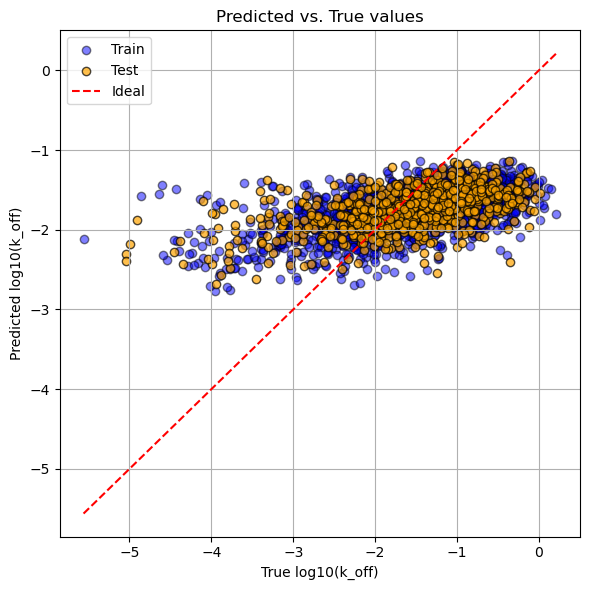

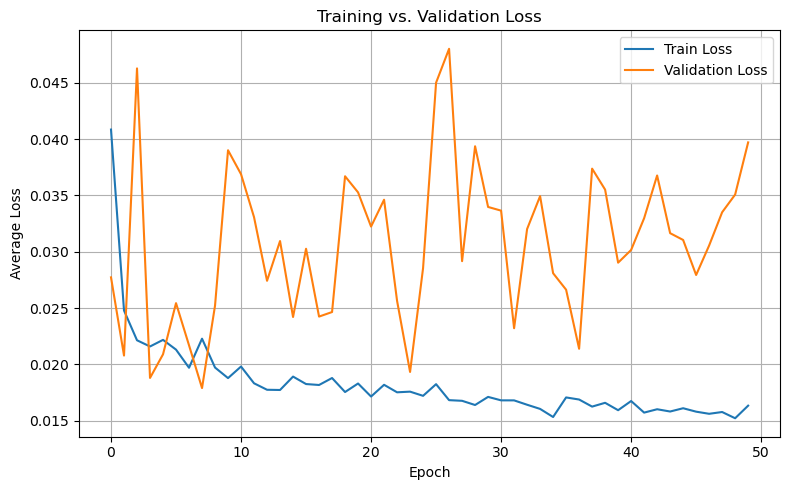

In [130]:

# evaluierung
model.eval()
with torch.no_grad():
    #test predictions

    y_test_pred_scaled = model(test_ds.tensors[0]).numpy()
    y_test_pred = y_scaler.inverse_transform(y_test_pred_scaled)
    y_test_true = y_scaler.inverse_transform(test_ds.tensors[1].numpy())

    # Train Predictions
    y_train_pred_scaled = model(train_ds.tensors[0]).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred_scaled)
    y_train_true = y_scaler.inverse_transform(train_ds.tensors[1].numpy())

mae = mean_absolute_error(y_test_true, y_test_pred)
r2 = r2_score(y_test_true, y_test_pred)
print(f"\nTest MAE: {mae:.4f} | R²: {r2:.4f}")

#scatter plot of predicted vs true values
plt.figure(figsize=(6, 6))
plt.scatter(y_train_true, y_train_pred, alpha=0.5, label='Train', c='blue', edgecolors='k')
plt.scatter(y_test_true, y_test_pred, alpha=0.7, label='Test', c='orange', edgecolors='k')
min_val = min(y_train_true.min(), y_test_true.min())
max_val = max(y_train_true.max(), y_test_true.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal')
plt.xlabel("True log10(k_off)")
plt.ylabel("Predicted log10(k_off)")
plt.title("Predicted vs. True values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#plot der training + validation losse

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", color="tab:blue")
plt.plot(val_losses, label="Validation Loss", color="tab:orange")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()